# Experiment 4: Document at various levels for covid scice large and covid psychology large datasets

## 1. Article level

In [1]:
#importing libraries
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as s
import dataframe_image as dfi
import networkx as nx
import mantel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### LSA on covid-science.txt at article level

In [2]:
def load_data(path,file_name,seperator):
    """"
    Input  : path and file_name
    function: loading text file
    Output : number of words, document list
    """
    
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r", encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            i=i+1
            if text !='':
                document = document+text
                if text == seperator:
                    documents_list.append(document)
                    document = ''
        documents_list.append(document)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [3]:
document_list,titles,word_count_science=load_data("","covid-science-large.txt",'NEW_PAPER')

Number of words in text file : 274941
Total Number of Documents: 40


In [4]:
def preprocess_data(doc_set):
    """
    Input  : list of documents
    function: text preprocessing - word tokenize, removing english stopwords, and potter stemming 
    Output : clean text
    """
    # initialize regex tokenizer
    word_tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    eng_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    po_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = word_tokenizer.tokenize(raw)
        tokens = [i for i in tokens if len(i)>3]
        print(tokens)
        # removing english stop words from tokens
        stopped_tokens = [i for i in tokens if not i in eng_stop]
        # stemmed tokens
        stem_tokens = [po_stemmer.stem(i) for i in stopped_tokens]
        # list of tokens
        texts.append(stem_tokens)
    return texts

In [5]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnetmethodology', 'predicting', 'covid', '19based', 'chest', 'imagess', 'tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herreraabstract', 'currently', 'coronavirus', 'disease', 'covid', 'most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans', 'orchest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'mostmedical', 'centers', 'hence', 'many', 'cases', 'imagesbecome', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networkshave', 'great', 'potential', 'building', 'covid', 'triage', 'systemsand', 'detecting', 'covid', 'patients', 'especially', 'patients', 'withlow', 'severity', 'unfortunately', 'current', 'databases', 'allowbuilding', 'such', 'systems', 'they', 'highly', 'heterog

In [6]:
# preparing corpus for LSA
def prepare_corpus(doc_clean):
    """
    Input  : preprossed document
    function: creating term dictionary and document term matrix
    Output : term dictionary and Document Term Matrix
    """
    # every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    term_dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    docu_term_matrix = [term_dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return term_dictionary,docu_term_matrix

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : preprocessed document, number of topics and word count
    function: create LSA model using gensim
    Output : return LSA model
    """
    term_dictionary,docu_term_matrix=prepare_corpus(doc_clean)
    # LSA model
    lsamodel = LsiModel(docu_term_matrix, num_topics=number_of_topics, id2word = term_dictionary)  # train model
    return lsamodel

In [8]:
# LSA Model
number_of_topics=25
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [9]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_articles = create_gensim_lsa_model(clean_text,number_of_topics,words)

In [10]:
#top 5 words from model lsa
dict(model_science.show_topic(0, topn=5))

{'covid': 0.5140048530952065,
 'imag': 0.25326452105798253,
 'model': 0.23714000415930525,
 'use': 0.23493416886438223,
 'data': 0.21392165729076498}

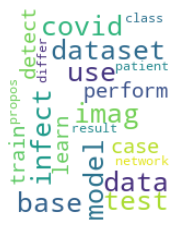

In [11]:
#wordcloud of top 10 words from the documents
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph21.png')

In [12]:
# cosine similarity of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled24.png')

cosine-similarity
           covid       imag      model        use       data
covid          1   0.107455  0.0469536   0.263832   0.172124
imag    0.107455          1 -0.0734307   0.108349 -0.0538667
model  0.0469536 -0.0734307          1  0.0857265  0.0055496
use     0.263832   0.108349  0.0857265          1  0.0192471
data    0.172124 -0.0538667  0.0055496  0.0192471          1


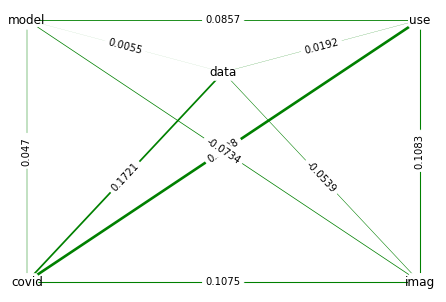

In [13]:
#networkx for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig24.png')

### LSA on covid-psychology-large.txt at article level

In [14]:
#loading dataset
document_list,titles,word_count_psy=load_data("","covid-psychology-large.txt",'NEW PAPER')

Number of words in text file : 183592
Total Number of Documents: 40


In [15]:
#data preprocessing
clean_text=preprocess_data(document_list)

['international', 'sociology2021', 'author', '2020article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissionsdoi', '1177', '0268580920948807journals', 'sagepub', 'home', 'isspsychology', 'politics', 'ofcovid', 'misinfodemics', 'peoplebelieve', 'misinfodemics', 'sonia', 'mukhtaruniversity', 'management', 'technology', 'lahore', 'pakistanabstractmisinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adversehealth', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicateevidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects', 'ofmisinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevierabout', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'reviewed', 'this', 'article', 'thisreview', 'examin

In [16]:
# LSA Model
number_of_topics=25
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))#dict and encoding matrix values


In [17]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_articles=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [18]:
#dictionary of top 5 words
dict(model_psy.show_topic(0,topn=5))

{'covid': 0.2898611145723357,
 '2020': 0.2862536527658803,
 'psycholog': 0.28058846178894215,
 'student': 0.2670404119683266,
 'pandem': 0.19867186971131373}

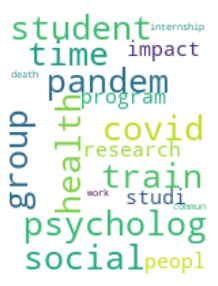

In [19]:
#wordcloud of top 10 words from lsa
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph22.png')

In [20]:
#cosine similarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled25.png')

cosine-similarity
               covid       2020  psycholog    student     pandem
covid              1   0.305279   0.150688  0.0723404    0.28409
2020        0.305279          1   0.138506 -0.0647919   0.291954
psycholog   0.150688   0.138506          1  0.0712322   0.128405
student    0.0723404 -0.0647919  0.0712322          1  0.0743237
pandem       0.28409   0.291954   0.128405  0.0743237          1


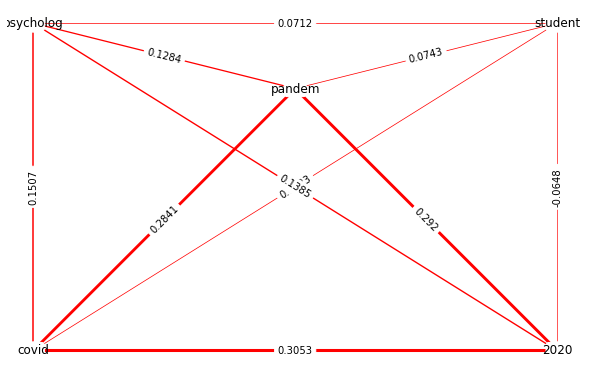

In [21]:
#networkx garph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig25.png')

In [22]:
# defining mantel test function
def mantel_test(n):
    #all words from corpus
    words_science = dict(model_science.show_topic(0, topn=word_count_science))
    words_psy = dict(model_psy.show_topic(0, topn=word_count_psy))
    #top words from the corpus
    top_words_science = dict(model_science.show_topic(0, topn=n)) 
    top_words_psy = dict(model_psy.show_topic(0,topn=n)) 

    #Finding out the weights of top 5 law words in covid science and updating their weights w.r.t psychology dataset 
    c={} 
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)
    #Finding out the weights of top 5 law words in covid psychology and updating their weights w.r.t covid science dataset 
    b={}
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for top 10 words in covid science
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_science.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace of top 10 words in psychology dataset
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_psy.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=10000, method='pearson', tail='upper')

In [23]:
#mantel test for 10 word network
mantel_test(5)

Pairwise-distance
              covid      2020 psycholog      student       pandem      imag  \
covid             0  0.702842  0.716739     0.918356     0.680495   1.01902   
2020       0.702842         0  0.290158     0.653557     0.380614  0.861552   
psycholog  0.716739  0.290158         0      0.55126     0.276821  0.806033   
student    0.918356  0.653557   0.55126  1.05367e-08     0.637377  0.973622   
pandem     0.680495  0.380614  0.276821     0.637377  5.26836e-09  0.875786   
imag        1.01902  0.861552  0.806033     0.973622     0.875786         0   
model       1.03673  0.786081  0.784766     0.963188     0.807124   1.16537   
use         0.74204  0.544595  0.460391     0.676651     0.548179  0.884217   
data       0.952954  0.856791  0.763671     0.961593     0.823599    1.1404   

                 model       use      data  
covid          1.03673   0.74204  0.952954  
2020          0.786081  0.544595  0.856791  
psycholog     0.784766  0.460391  0.763671  
student    

(-0.4264559490750131, 0.8876, -1.2680325703061341)

In [24]:
#mantel test for 20 word network
mantel_test(10)

Pairwise-distance
              covid      2020 psycholog      student       pandem     train  \
covid             0  0.702842  0.716739     0.918356     0.680495    0.6956   
2020       0.702842         0  0.290158     0.653557     0.380614  0.398691   
psycholog  0.716739  0.290158         0      0.55126     0.276821   0.32078   
student    0.918356  0.653557   0.55126  1.05367e-08     0.637377  0.660347   
pandem     0.680495  0.380614  0.276821     0.637377  5.26836e-09  0.444486   
train        0.6956  0.398691   0.32078     0.660347     0.444486         0   
social     0.835514   0.48014   0.37424     0.670737      0.44328  0.458718   
health     0.694141  0.289767  0.196136      0.55408     0.280294  0.385114   
time       0.751346  0.310403  0.322936     0.660202      0.43743  0.468233   
group      0.947395   0.60563  0.585684     0.800901     0.652223  0.678309   
imag        1.01902  0.861552  0.806033     0.973622     0.875786  0.735491   
model       1.03673  0.786081  0.7

(-0.2857142874137023, 0.9018, -1.2970979073940034)

## 2. 2-3 paragraphs

### LSA on covid-science.txt at 2-3 paragraph level

In [25]:
#loading dataset
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r",encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for word in words:
                i=i+1
                document = document+word+' '
                if i == 200:
                    documents_list.append(document)
                    document,i = '',0
                    if len(documents_list) == 2:
                        break
    print("Total Number of Documents:",len(documents_list))
    #titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [26]:
document_list,titles,word_count_science=load_data("","covid-science-large.txt")

Number of words in text file : 274941
Total Number of Documents: 2


In [27]:
#data preprocessing
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet', 'methodology', 'predicting', 'covid', 'based', 'chest', 'images', 'tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herrera', 'abstract', 'currently', 'coronavirus', 'disease', 'covid', 'most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans', 'chest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'most', 'medical', 'centers', 'hence', 'many', 'cases', 'images', 'become', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networks', 'have', 'great', 'potential', 'building', 'covid', 'triage', 'systems', 'detecting', 'covid', 'patients', 'especially', 'patients', 'with', 'severity', 'unfortunately', 'current', 'databases', 'allow', 'building', 'such', 'systems', 'they', 'high

In [28]:
# LSA Model
number_of_topics=2
words_nscience=len(clean_text[0])+len(clean_text[1])
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words_nscience)
words_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [29]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_p=create_gensim_lsa_model(clean_text,number_of_topics,words_nscience)

In [30]:
#dictionary of top 5 word from lsa
dict(model_science.show_topic(0, topn=5))

{'support': -0.3038609553429639,
 '2020': -0.23522191481735827,
 'granada': -0.23033778261060098,
 'covid': -0.2172263668489119,
 'research': -0.2025739702286426}

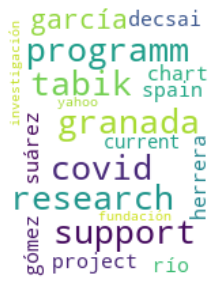

In [31]:
#word cloud of top 10 words from lsa
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph23.png')

In [32]:
#cosine similarity matrix of top 5 words
a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn = words_nscience))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled26.png')

cosine-similarity
           support      2020   granada     covid  research
support          1  0.524928  0.955931 -0.115612         1
2020      0.524928         1  0.751685  0.784751  0.524928
granada   0.955931  0.751685         1  0.181107  0.955931
covid    -0.115612  0.784751  0.181107         1 -0.115612
research         1  0.524928  0.955931 -0.115612         1


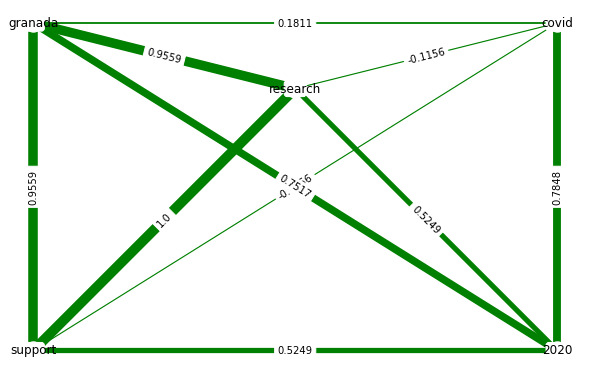

In [33]:
#networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig26.png')

### LSA of covid-psycology.txt at 2-3 paragraph level

In [34]:
#data loading
document_list,titles,word_count_psy=load_data("","covid-psychology-large.txt")

Number of words in text file : 183592
Total Number of Documents: 2


In [35]:
#data preprocessing
clean_text=preprocess_data(document_list)

['international', 'sociology', '2021', 'author', '2020', 'article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissions', '1177', '0268580920948807', 'journals', 'sagepub', 'home', 'psychology', 'politics', 'covid', 'misinfodemics', 'people', 'believe', 'misinfodemics', 'sonia', 'mukhtar', 'university', 'management', 'technology', 'lahore', 'pakistan', 'abstract', 'misinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adverse', 'health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate', 'evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects', 'misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier', 'about', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'reviewed', 'this', 'a

In [36]:
# LSA Model
number_of_topics=2
words_npsy=len(clean_text[0])+len(clean_text[1])
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words_npsy)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [37]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_p = create_gensim_lsa_model(clean_text,number_of_topics,words_npsy)

In [38]:
#dictionary of top 5 words
dict(model_psy.show_topic(0, topn=5))

{'misinfodem': 0.49362666559416474,
 'covid': 0.3571916107745928,
 'articl': 0.21002057347124553,
 'mechan': 0.1471710373033481,
 'health': 0.14717103730334802}

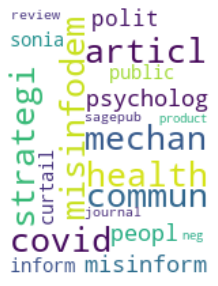

In [39]:
#word cloud of top 10 words
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph24.png')

In [40]:
# cosine similarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words_npsy))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled27.png')

cosine-similarity
           misinfodem     covid    articl    mechan    health
misinfodem          1  0.977431  0.994116  0.761706  0.761706
covid        0.977431         1  0.948797  0.881393  0.881393
articl       0.994116  0.948797         1  0.687043  0.687043
mechan       0.761706  0.881393  0.687043         1         1
health       0.761706  0.881393  0.687043         1         1


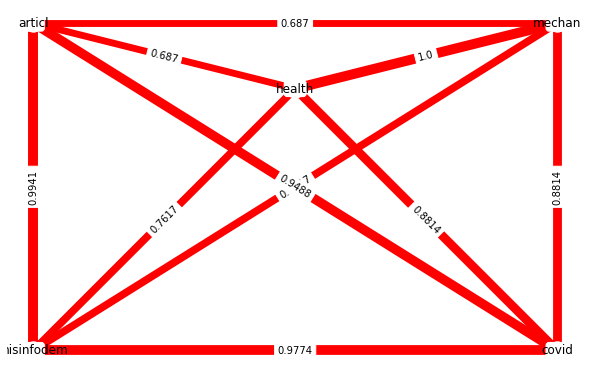

In [41]:
#Networkx graph of top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig27.png')

In [42]:
#mantel test for 10 word network
mantel_test(5)

Pairwise-distance
           misinfodem        covid    articl mechan health   support  \
misinfodem          0            0         0      0      0         0   
covid               0  7.45058e-09  0.360337      0      0  0.608033   
articl              0     0.360337         0      0      0  0.404283   
mechan              0            0         0      0      0         0   
health              0            0         0      0      0         0   
support             0     0.608033  0.404283      0      0         0   
2020                0     0.282616  0.208896      0      0  0.327071   
granada             0     0.457677  0.252649      0      0  0.161988   
research            0     0.526543  0.280864      0      0  0.126325   

                2020    granada   research  
misinfodem         0          0          0  
covid       0.282616   0.457677   0.526543  
articl      0.208896   0.252649   0.280864  
mechan             0          0          0  
health             0          0     

(-0.1562215918892801, 0.701, -0.6326413856143783)

In [43]:
#mantel test for 20 word network
mantel_test(10)

Pairwise-distance
           misinfodem        covid    articl mechan health commun strategi  \
misinfodem          0            0         0      0      0      0        0   
covid               0  7.45058e-09  0.360337      0      0      0        0   
articl              0     0.360337         0      0      0      0        0   
mechan              0            0         0      0      0      0        0   
health              0            0         0      0      0      0        0   
commun              0            0         0      0      0      0        0   
strategi            0            0         0      0      0      0        0   
psycholog           0            0         0      0      0      0        0   
misinform           0            0         0      0      0      0        0   
public              0     0.445426  0.109024      0      0      0        0   
support             0     0.608033  0.404283      0      0      0        0   
2020                0     0.282616  0.208896  

(-0.16261206284337587, 0.8495, -1.04195817588891)

## 3. Paragraph level

### LSA on covid-science.txt at paragraph level

In [44]:
#loading dataset
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r",encoding='UTF8') as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            if text !='':
                documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [45]:
document_list,titles,word_count_science=load_data("","covid-science-large.txt")

Number of words in text file : 274941
Total Number of Documents: 31577


In [46]:
#data preprocessing
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet']
['methodology', 'predicting', 'covid']
['based', 'chest', 'images']
['tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte']
['guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova']
['olmedo', 'sánchez', 'herrera']
['abstract', 'currently', 'coronavirus', 'disease', 'covid']
['most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans']
['chest', 'images', 'computed', 'tomography']
['scanners', 'testing', 'available', 'most']
['medical', 'centers', 'hence', 'many', 'cases', 'images']
['become', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networks']
['have', 'great', 'potential', 'building', 'covid', 'triage', 'systems']
['detecting', 'covid', 'patients', 'especially', 'patients', 'with']
['severity', 'unfortunately', 'current', 'databases', 'allow']
['building', 'such', 'systems'

In [47]:
# LSA Model
number_of_topics=100
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_law =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [48]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [49]:
#dictionary of top 5 words
dict(model_science.show_topic(0, topn=5))

{'covid': 0.8256400912768749,
 'imag': 0.24294931530827157,
 'model': 0.190294345224982,
 'use': 0.1841813457165905,
 'detect': 0.14281538766739102}

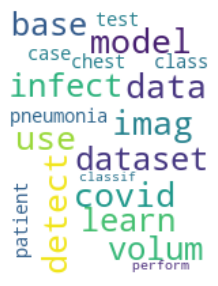

In [50]:
#word cloud of top 10 words
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph25.png')

In [51]:
# Cosine similarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled28.png')

cosine-similarity
              covid         imag        model          use      detect
covid             1  0.000700957 -7.58371e-05 -0.000371984  0.00520228
imag    0.000700957            1  0.000868205 -0.000432478  0.00039015
model  -7.58371e-05  0.000868205            1 -4.46218e-05 -0.00210096
use    -0.000371984 -0.000432478 -4.46218e-05            1  0.00022151
detect   0.00520228   0.00039015  -0.00210096   0.00022151           1


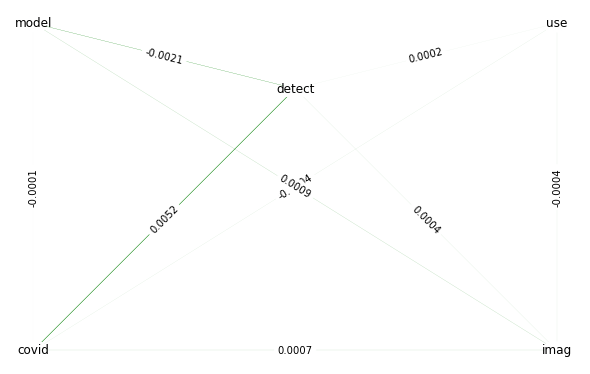

In [52]:
#networkx graph of top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig28.png')

### LSA on covid-psychology-large.txt at paragraph level

In [53]:
#loading data
document_list,titles,word_count_psy=load_data("","covid-psychology-large.txt")

Number of words in text file : 183592
Total Number of Documents: 18522


In [54]:
#data preprocesing
clean_text=preprocess_data(document_list)

['international', 'sociology']
['2021']
['author', '2020']
['article', 'reuse', 'guidelines']
['sagepub', 'journals', 'permissions']
['1177', '0268580920948807']
['journals', 'sagepub', 'home']
['psychology', 'politics']
['covid', 'misinfodemics']
['people']
['believe', 'misinfodemics']
['sonia', 'mukhtar']
['university', 'management', 'technology', 'lahore', 'pakistan']
['abstract']
['misinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adverse']
['health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate']
['evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects']
['misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier']
['about', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'rev

In [55]:
# LSA Model
number_of_topics=100
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [56]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [57]:
#generating top 5 words form lsa
dict(model_psy.show_topic(0, topn=5))

{'2020': 0.5867463921244819,
 'covid': 0.4071883489033404,
 'psycholog': 0.3061861652069924,
 'pandem': 0.2779430420491234,
 'health': 0.23444970867587098}

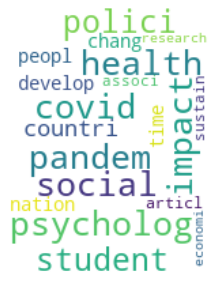

In [58]:
#wordclod for top 10 words
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph26.png')

In [59]:
# Cosine similarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled29.png')

cosine-similarity
                  2020        covid    psycholog       pandem       health
2020                 1 -0.000181265 -0.000892643  0.000282476 -0.000811633
covid     -0.000181265            1 -3.26851e-05  0.000850608  -0.00243693
psycholog -0.000892643 -3.26851e-05            1 -0.000796692  -0.00297452
pandem     0.000282476  0.000850608 -0.000796692            1 -0.000958762
health    -0.000811633  -0.00243693  -0.00297452 -0.000958762            1


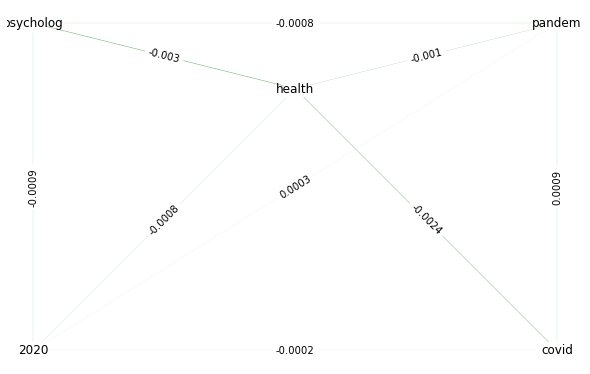

In [60]:
#networkx graph of top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig29.png')

In [61]:
#mantel test for 10 word network
mantel_test(5)

Pairwise-distance
               2020     covid psycholog    pandem       health      imag  \
2020              0   1.36666  0.934002   1.32086       1.2907   1.36248   
covid       1.36666         0  0.996012    1.3575      1.34232   1.40654   
psycholog  0.934002  0.996012         0  0.923107     0.897853  0.993867   
pandem      1.32086    1.3575  0.923107         0      1.29287   1.35564   
health       1.2907   1.34232  0.897853   1.29287  2.10734e-08   1.34081   
imag        1.36248   1.40654  0.993867   1.35564      1.34081         0   
model       1.36538   1.40674  0.993419   1.35499      1.33957   1.40463   
use         1.36557   1.40914  0.996611   1.35691      1.34055   1.40774   
detect      1.35037   1.39005  0.974971   1.34948      1.32741   1.39195   

              model       use    detect  
2020        1.36538   1.36557   1.35037  
covid       1.40674   1.40914   1.39005  
psycholog  0.993419  0.996611  0.974971  
pandem      1.35499   1.35691   1.34948  
health     

(-0.31738225480066284, 0.9036, -0.9287861176988951)

In [62]:
#mantel test for 20 word network
mantel_test(10)

Pairwise-distance
               2020     covid  psycholog    pandem       health    social  \
2020              0   1.36666   0.934002   1.32086       1.2907   1.01582   
covid       1.36666         0   0.996012    1.3575      1.34232   1.08085   
psycholog  0.934002  0.996012          0  0.923107     0.897853  0.425651   
pandem      1.32086    1.3575   0.923107         0      1.29287   1.00801   
health       1.2907   1.34232   0.897853   1.29287  2.10734e-08  0.979298   
social      1.01582   1.08085   0.425651   1.00801     0.979298         0   
impact     0.950754  0.995943   0.157101   0.88269     0.884908  0.435621   
polici     0.937932  0.996663  0.0448366    0.9206     0.893999  0.426208   
student      1.2335   1.27581   0.794231   1.22584      1.21903  0.905925   
countri    0.950655   1.01329   0.185665  0.916894     0.889609  0.423086   
imag        1.36248   1.40654   0.993867   1.35564      1.34081   1.08009   
model       1.36538   1.40674   0.993419   1.35499      1.

(-0.25663333170429653, 0.8857, -1.1763298155997657)

In [63]:
## Vertical mantel test
### Considering two spaces in matel tests as
### Article level -----> 2-3 Paragraph level , 
### Article---->Paragraph level,
### Paragraph----> 2-3 Paragraph level

In [64]:
def mantel_test_verticle(model_a,model_b,n):
   
    #all words from the cleaned documents

    words_science = dict(model_a.show_topic(0, topn=word_count_science))
    words_psy = dict(model_b.show_topic(0, topn=word_count_psy))
   
    #top 5 words from the documents

    top_words_science = dict(model_a.show_topic(0, topn=n)) 
    top_words_psy = dict(model_b.show_topic(0,topn=n)) 

    #Finding out the weights of top 5 law words in  model_a level and updating their weights w.r.t model b dataset 
    c={} 
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)
    
    #Finding out the weights of top 5 law words in model b and updating their weights w.r.t model a dataset
    b={} 
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for top 10 words in model a
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_a.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distance for top 10 words in model b
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_b.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=10000, method='pearson', tail='upper')

In [65]:
mantel_test_verticle(model_science_articles,model_science_p,5)

Pairwise-distance
           support         2020    granada    covid   programm     imag  \
support          0     0.694329   0.243552  1.42891   0.259057  1.65856   
2020      0.694329  1.05367e-08   0.589628  1.40568   0.581793   1.7231   
granada   0.243552     0.589628          0  1.42116  0.0533633  1.61975   
covid      1.42891      1.40568    1.42116        0    1.42763  2.03803   
programm  0.259057     0.581793  0.0533633  1.42763          0  1.61449   
imag       1.65856       1.7231    1.61975  2.03803    1.61449        0   
model      1.65136      1.57216    1.56798  2.07345    1.56797  2.33074   
use       0.884093      1.08919    0.92001  1.48408   0.920214  1.76843   
data       1.45815      1.71358    1.53404  1.90591    1.52988   2.2808   

            model       use     data  
support   1.65136  0.884093  1.45815  
2020      1.57216   1.08919  1.71358  
granada   1.56798   0.92001  1.53404  
covid     2.07345   1.48408  1.90591  
programm  1.56797  0.920214  1.52988

(0.1407286765878476, 0.2938, 0.5905114322083113)

In [66]:
mantel_test_verticle(model_science_articles,model_science_paragraph,5)

Pairwise-distance
          covid     imag    model      use   detect     data
covid         0  2.03803  2.07345  1.48408  1.46402  1.90591
imag    2.03803        0  2.33074  1.76843  1.66915   2.2808
model   2.07345  2.33074        0  1.74983  1.56905  2.18411
use     1.48408  1.76843  1.74983        0  1.14176  1.76952
detect  1.46402  1.66915  1.56905  1.14176        0  1.63152
data    1.90591   2.2808  2.18411  1.76952  1.63152        0
Pairwise-distance
              covid         imag    model      use       detect         data
covid   2.98023e-08      1.40622  1.40634  1.40901      1.39056      1.40437
imag        1.40622  1.49012e-08  1.40413  1.40753      1.39251      1.40654
model       1.40634      1.40413        0  1.40682      1.39364      1.40186
use         1.40901      1.40753  1.40682        0      1.39454       1.4047
detect      1.39056      1.39251  1.39364  1.39454  2.10734e-08      1.38899
data        1.40437      1.40654  1.40186   1.4047      1.38899  1.49012e-0

(0.5267820518396905, 0.19722222222222222, 1.207399320553872)

In [67]:
mantel_test_verticle(model_science_p,model_science_paragraph,5)

Pairwise-distance
            covid     imag    model      use   detect   support     2020  \
covid           0  1.52372  2.54797  2.54797  2.54797   4.29945   1.9984   
imag      1.52372        0  1.04988  1.04988  1.04988   3.43628  1.33987   
model     2.54797  1.04988        0        0        0   2.85871  1.47712   
use       2.54797  1.04988        0        0        0   2.85871  1.47712   
detect    2.54797  1.04988        0        0        0   2.85871  1.47712   
support   4.29945  3.43628  2.85871  2.85871  2.85871         0  2.31274   
2020       1.9984  1.33987  1.47712  1.47712  1.47712   2.31274        0   
granada   3.23626  2.29085   1.7865   1.7865   1.7865   1.14543  1.24107   
programm  3.72322  2.66513  1.98601  1.98601  1.98601  0.893249   1.7428   

           granada  programm  
covid      3.23626   3.72322  
imag       2.29085   2.66513  
model       1.7865   1.98601  
use         1.7865   1.98601  
detect      1.7865   1.98601  
support    1.14543  0.893249  
2020

(-0.025229164267055907, 0.4952, -0.11650723344023295)

In [68]:
mantel_test_verticle(model_psy_articles,model_psy_p,5)

Pairwise-distance
             misinfodem        covid    articl    mechan   health  \
misinfodem  7.45058e-09      1.19883  0.650347  0.363944  1.34779   
covid           1.19883  2.98023e-08   1.17254   1.13414  1.67307   
articl         0.650347      1.17254         0  0.441214  1.32131   
mechan         0.363944      1.13414  0.441214         0   1.3049   
health          1.34779      1.67307   1.32131    1.3049        0   
2020            1.44097      1.48398   1.23638   1.37506  1.58891   
psycholog       1.21365      1.44499   1.05027    1.0956  1.58757   
student         1.59112      1.83153   1.54613   1.52132  2.09448   
pandem         0.913109      1.18534  0.766561  0.775584   1.2713   

                   2020 psycholog      student    pandem  
misinfodem      1.44097   1.21365      1.59112  0.913109  
covid           1.48398   1.44499      1.83153   1.18534  
articl          1.23638   1.05027      1.54613  0.766561  
mechan          1.37506    1.0956      1.52132  0.77558

(-0.5439167986699588, 0.9719, -1.845298403327228)

In [69]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,5)

Pairwise-distance
                  2020        covid psycholog   pandem   health      student
2020       2.10734e-08      1.48398   1.61227  1.35571  1.58891      2.10215
covid          1.48398  2.98023e-08   1.44499  1.18534  1.67307      1.83153
psycholog      1.61227      1.44499         0  1.24541  1.58757      1.79664
pandem         1.35571      1.18534   1.24541        0   1.2713      1.65464
health         1.58891      1.67307   1.58757   1.2713        0      2.09448
student        2.10215      1.83153   1.79664  1.65464  2.09448  2.98023e-08
Pairwise-distance
                  2020    covid psycholog       pandem   health  student
2020       1.49012e-08  1.40884   1.40575      1.40701  1.39426  1.40523
covid          1.40884        0   1.40488      1.40624  1.39589  1.40523
psycholog      1.40575  1.40488         0      1.40369  1.39092  1.40062
pandem         1.40701  1.40624   1.40369  2.58096e-08  1.39311    1.404
health         1.39426  1.39589   1.39092      1.39311      

(-0.2379830910039947, 0.7527777777777778, -0.5501466047116179)

In [70]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,5)

Pairwise-distance
                2020    covid    psycholog       pandem    health misinfodem  \
2020               0  2.07845      1.20521      1.31385  0.554403    3.31627   
covid        2.07845        0      1.66321      2.67852   1.65813    1.33926   
psycholog    1.20521  1.66321  2.63418e-08      2.45969   1.31385    2.55053   
pandem       1.31385  2.67852      2.45969  2.63418e-08   1.20521    4.01777   
health      0.554403  1.65813      1.31385      1.20521         0    2.96288   
misinfodem   3.31627  1.33926      2.55053      4.01777   2.96288          0   
articl       1.33926  1.10881     0.554403      2.41043   1.20521    2.07845   
mechan      0.554403  1.65813      1.31385      1.20521         0    2.96288   

              articl       mechan  
2020         1.33926     0.554403  
covid        1.10881      1.65813  
psycholog   0.554403      1.31385  
pandem       2.41043      1.20521  
health       1.20521            0  
misinfodem   2.07845      2.96288  
articl   

(-0.269143448460167, 0.7513, -0.8977474365216084)

In [71]:
mantel_test_verticle(model_science_articles,model_science_p,10)

Pairwise-distance
           support         2020    granada    covid   programm  research  \
support          0     0.694329   0.243552  1.42891   0.259057  0.456066   
2020      0.694329  1.05367e-08   0.589628  1.40568   0.581793  0.597341   
granada   0.243552     0.589628          0  1.42116  0.0533633  0.353174   
covid      1.42891      1.40568    1.42116        0    1.42763   1.38175   
programm  0.259057     0.581793  0.0533633  1.42763          0  0.346901   
research  0.456066     0.597341   0.353174  1.38175   0.346901         0   
tabik     0.239679     0.599147  0.0405284  1.41732  0.0936909  0.363266   
garcía    0.251375     0.586015  0.0314383  1.42391  0.0273959   0.35068   
project   0.341003     0.617683   0.202709  1.44224    0.17841  0.351158   
decsai    0.254221     0.583304  0.0400225  1.42583  0.0133408  0.347713   
imag       1.65856       1.7231    1.61975  2.03803    1.61449   1.61237   
model      1.65136      1.57216    1.56798  2.07345    1.56797   1.611

(0.10997676111624198, 0.2862, 0.6143788521576996)

In [72]:
mantel_test_verticle(model_science_articles,model_science_paragraph,10)

Pairwise-distance
           covid     imag    model       use    detect     data  dataset  \
covid          0  2.03803  2.07345   1.48408   1.46402  1.90591  1.90698   
imag     2.03803        0  2.33074   1.76843   1.66915   2.2808  1.79918   
model    2.07345  2.33074        0   1.74983   1.56905  2.18411  1.94443   
use      1.48408  1.76843  1.74983         0   1.14176  1.76952  1.34406   
detect   1.46402  1.66915  1.56905   1.14176         0  1.63152  1.32155   
data     1.90591   2.2808  2.18411   1.76952   1.63152        0   1.8182   
dataset  1.90698  1.79918  1.94443   1.34406   1.32155   1.8182        0   
learn    1.76094  1.97963    1.949   1.33702   1.24658  1.94162  1.71229   
volum    1.39123  1.60994  1.58588  0.921589  0.676524  1.54176  1.16116   
infect   1.83833  2.08225  1.89989   1.63891   1.43678  2.05822   1.8766   
base     1.55093  1.77436  1.71891   1.05984  0.873666  1.57974  1.44021   
test     1.76269    2.117  1.99214   1.38242   1.31697  1.99553   1.63

(0.5077909941233221, 0.0087, 1.7862279888090011)

In [73]:
mantel_test_verticle(model_science_p,model_science_paragraph,10)

Pairwise-distance
            covid     imag     model       use    detect      data   dataset  \
covid           0  1.52372   2.54797   2.54797   2.54797    3.2917   2.54797   
imag      1.52372        0   1.04988   1.04988   1.04988    1.9984   1.04988   
model     2.54797  1.04988         0         0         0   1.14543         0   
use       2.54797  1.04988         0         0         0   1.14543         0   
detect    2.54797  1.04988         0         0         0   1.14543         0   
data       3.2917   1.9984   1.14543   1.14543   1.14543         0   1.14543   
dataset   2.54797  1.04988         0         0         0   1.14543         0   
learn     2.54797  1.04988         0         0         0   1.14543         0   
volum           0        0         0         0         0         0         0   
infect          0        0         0         0         0         0         0   
support   4.29945  3.43628   2.85871   2.85871   2.85871    1.7865   2.85871   
2020       1.9984  1.3

(0.05924934236844332, 0.3857, 0.3309664504130001)

In [74]:
mantel_test_verticle(model_psy_articles,model_psy_p,10)

Pairwise-distance
             misinfodem        covid    articl    mechan   health    commun  \
misinfodem  7.45058e-09      1.19883  0.650347  0.363944  1.34779  0.967211   
covid           1.19883  2.98023e-08   1.17254   1.13414  1.67307   1.54277   
articl         0.650347      1.17254         0  0.441214  1.32131  0.945772   
mechan         0.363944      1.13414  0.441214         0   1.3049  0.921909   
health          1.34779      1.67307   1.32131    1.3049        0   1.64385   
commun         0.967211      1.54277  0.945772  0.921909  1.64385         0   
strategi       0.419676      1.19176  0.490353  0.327267  1.33014  0.944397   
psycholog       1.21365      1.44499   1.05027    1.0956  1.58757    1.2675   
misinform      0.179496      1.15976  0.525198  0.193913  1.31222  0.932335   
public          0.42451      1.16644  0.803435  0.535868  1.26582   1.05285   
2020            1.44097      1.48398   1.23638   1.37506  1.58891   1.64904   
student         1.59112      1.831

(-0.46962449360728215, 0.9914, -2.3102322654980028)

In [75]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,10)

Pairwise-distance
                  2020        covid psycholog    pandem   health       social  \
2020       2.10734e-08      1.48398   1.61227   1.35571  1.58891      1.68498   
covid          1.48398  2.98023e-08   1.44499   1.18534  1.67307      1.59148   
psycholog      1.61227      1.44499         0   1.24541  1.58757      1.66799   
pandem         1.35571      1.18534   1.24541         0   1.2713       1.3521   
health         1.58891      1.67307   1.58757    1.2713        0      1.74427   
social         1.68498      1.59148   1.66799    1.3521  1.74427  2.10734e-08   
impact         1.30498      1.18023   1.12893  0.795946  1.50378      1.34668   
polici         1.28835      1.14473   1.07787  0.788964  1.39658      1.23092   
student        2.10215      1.83153   1.79664   1.65464  2.09448      1.88077   
countri        1.63319     0.863671   1.24316   1.07916  1.60392       1.4604   
train          1.74142      1.51068   1.34992   1.09245  1.66229      1.59658   
time      

(0.43606282874936597, 0.0159, 1.5557018850462125)

In [76]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,10)

Pairwise-distance
                2020    covid    psycholog       pandem    health  \
2020               0  2.07845      1.20521      1.31385  0.554403   
covid        2.07845        0      1.66321      2.67852   1.65813   
psycholog    1.20521  1.66321  2.63418e-08      2.45969   1.31385   
pandem       1.31385  2.67852      2.45969  2.63418e-08   1.20521   
health      0.554403  1.65813      1.31385      1.20521         0   
social       1.31385  2.67852      2.45969  2.63418e-08   1.20521   
impact      0.538987  2.20461     0.892838      1.83335  0.998224   
polici             0        0            0            0         0   
student            0        0            0            0         0   
countri            0        0            0            0         0   
misinfodem   3.31627  1.33926      2.55053      4.01777   2.96288   
articl       1.33926  1.10881     0.554403      2.41043   1.20521   
mechan      0.554403  1.65813      1.31385      1.20521         0   
commun      0.55

(-0.19957243325925628, 0.8382, -0.990172106766751)